In [1]:
tests_old = 'test_NHA.txt  test_RHC.txt  test_SA.txt  test_VOC.txt'.split()
# tests

In [2]:
tests = tests_old +['ned.testb'] # for the names

In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification, Trainer, TrainingArguments, AutoModel
from datasets import load_dataset, load_metric, Dataset, DatasetDict
import numpy as np
from seqeval.metrics import f1_score, precision_score, recall_score, classification_report
from data_utils import prepare_data, convert_to_dataset

# train and val are redundant but we need the labels, sooo
train = prepare_data('/ivi/ilps/personal/vprovat/KB/data/AITrainingset/Data/train.txt')
val = prepare_data('/ivi/ilps/personal/vprovat/KB/data/AITrainingset/Data/validation.txt')

tests_prepared = [
     prepare_data('/ivi/ilps/personal/vprovat/KB/data/AITrainingset/Data/'+test) for test in tests_old
]

tests_prepared += [
     prepare_data('/ivi/ilps/personal/vprovat/KB/data/Dutch_conll/ned.testb')
]

  0%|          | 0/8040 [00:00<?, ?it/s]

  0%|          | 0/2150 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/5076 [00:00<?, ?it/s]

In [4]:
label_list = sorted(list(set([token_data[1] for sentence in train for token_data in sentence if token_data])))

label_list = label_list
# print(label_list_new)
id2label_original = {i: label for i, label in enumerate(label_list)}
label2id = {label: i for i, label in enumerate(label_list)}
label_map = {label: i for i, label in enumerate(label_list)}
label_map.update({'B-ORG': label2id['O'],
                  'B-MISC': label2id['O'], 
                  'I-ORG': label2id['O'],
                  'I-MISC': label2id['O']})

train_data = convert_to_dataset(train, label_map)
val_data = convert_to_dataset(val, label_map)
test_data = [convert_to_dataset(test, label_map)
             for test in tests_prepared]

In [5]:
label_list

['B-LOC', 'B-PER', 'B-TIME', 'I-LOC', 'I-PER', 'I-TIME', 'O']

In [6]:
id2label = id2label_original

In [7]:
dct = {
    "train": train_data,
    "validation": val_data}
for i, test in enumerate(tests):
    dct[test.split('.')[0]] = test_data[i]

datasets = DatasetDict(dct)

In [8]:
def get_predictions(model_name, dataset_name):
    global tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
    global model
    model = AutoModelForTokenClassification.from_pretrained(model_name)
    tokenized_datasets = datasets.map(tokenize_and_align_labels, batched=True)
    
    global id2label
    id2label = model.config.id2label
#     global label2id
#     label2id = model.config.label2id
    
    trainer = Trainer(
        model=model,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )
    

    preds = trainer.predict(tokenized_datasets[dataset_name])
    return preds

In [9]:
def clean_predictions(preds):
    predictions = np.argmax(preds.predictions, axis=2)
    labels = preds.label_ids

    # Remove ignored index (special tokens)
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2label_original[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    
    return true_predictions, true_labels

In [10]:
def extract_wrong_predictions(preds): # experimental, will be improved
    true_predictions, true_labels = clean_predictions(preds)
    
    res = []
    for i in range(len(true_predictions)):
        if true_predictions[i] != true_labels[i]:
            res.append((i, true_predictions[i],true_labels[i]))
    return res


In [11]:
from sklearn.metrics import confusion_matrix
def get_predictions(model_name, dataset_name):
    global tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
    global model
    model = AutoModelForTokenClassification.from_pretrained(model_name)
    tokenized_datasets = datasets.map(tokenize_and_align_labels, batched=True)
    
    global id2label
    id2label = model.config.id2label
#     global label2id
#     label2id = model.config.label2id
    
    trainer = Trainer(
        model=model,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )
    

    preds = trainer.predict(tokenized_datasets[dataset_name])
    return preds
    
#     matrix = confusion_matrix(preds.label_ids, preds.predictions, label_list)
#     return matrix

In [12]:
def compute_metrics(eval_prediction):
    true_predictions, true_labels = clean_predictions(eval_prediction)
    return {
        "precision": precision_score(true_labels, true_predictions),
        "recall": recall_score(true_labels, true_predictions),
        "f1": f1_score(true_labels, true_predictions),
        "classification_report": classification_report(true_labels, true_predictions),
    }


def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True, padding=True, return_tensors='pt'
    )
    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

def data_collator(data):
    input_ids = [torch.tensor(item["input_ids"]) for item in data]
    attention_mask = [torch.tensor(item["attention_mask"]) for item in data]
    labels = [torch.tensor(item["labels"]) for item in data]

    input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask = torch.nn.utils.rnn.pad_sequence(attention_mask, batch_first=True, padding_value=0)
    labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=-100)


    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels,
    }


In [13]:
model_names = {'GysBERT': "/ivi/ilps/personal/vprovat/KB/models/GysBERT-NER-v2",
              'BERTje': "/ivi/ilps/personal/vprovat/KB/models/BERTje-NER-v2",
              'BERT-multi-cased': "/ivi/ilps/personal/vprovat/KB/models/BERT-multi-cased-NER-v2",
              'WikiNEuRal': "Babelscape/wikineural-multilingual-ner"}

In [14]:
datasets

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 11104
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 2761
    })
    test_NHA: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 51
    })
    test_RHC: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 3
    })
    test_SA: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 114
    })
    test_VOC: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 111
    })
    ned: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 5076
    })
})

In [15]:
all_preds = {}

for name, path in model_names.items():
    cur_preds = {}
    for test in tests+['ned.testb']:
        cur_preds[test] = get_predictions(path, test.split('.')[0])
    all_preds[name] = cur_preds

Map:   0%|          | 0/11104 [00:00<?, ? examples/s]

KeyboardInterrupt: 

In [42]:
import pickle

pickle.dump(all_preds, open('all_predictions.p','wb'))

In [16]:
import pickle
all_preds=pickle.load(open('all_predictions.p','rb'))

In [17]:
tests_by_century = {'21': ['ned.testb'],
                   '19': ['test_RHC.txt','test_NHA.txt'],
                   '17-18': ['test_VOC.txt','test_SA.txt']}

In [18]:
def flatten(stuff):
    return [item for entry in stuff for item in entry]

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay

def get_confusion_matrix(model_name, century,display=True):
    preds, labels = [], []
    for test in tests_by_century[century]:
        print(model_name, test)
        cur_preds, cur_labels = clean_predictions(all_preds[model_name][test])
        preds.extend(flatten(cur_preds))
        labels.extend(flatten(cur_labels))
        
    if display:
        return ConfusionMatrixDisplay.from_predictions(y_true=labels, 
                                                       y_pred=preds,
                                                       labels=label_list,
                                                      normalize='all')
    return confusion_matrix(labels, preds, label_list)

WikiNEuRal ned.testb


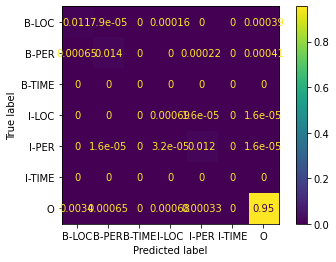

In [33]:
# model = AutoModelForTokenClassification.from_pretrained(model_names['WikiNEuRal']) # just to get the labels for WikiNEuRal
# id2label = model.config.id2label

matrix = get_confusion_matrix('WikiNEuRal', '21')

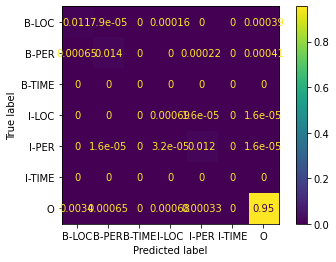

In [34]:
matrix.plot()

In [35]:
# all_preds['WikiNEuRal']['ned.testb']

In [19]:
confusion_matrices = {}

for model_name in model_names.keys():
    matrices = {}
    model = AutoModelForTokenClassification.from_pretrained(model_names[model_name]) # just to get the labels for WikiNEuRal
    id2label = model.config.id2label
    for century in tests_by_century.keys():
        matrices[century] = get_confusion_matrix(model_name, century)
    confusion_matrices[model_name] = matrices

GysBERT ned.testb


/home/vprovat/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass labels=['B-LOC', 'B-PER', 'B-TIME', 'I-LOC', 'I-PER', 'I-TIME', 'O'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/vprovat/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass labels=['B-LOC', 'B-PER', 'B-TIME', 'I-LOC', 'I-PER', 'I-TIME', 'O'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


GysBERT test_RHC.txt
GysBERT test_NHA.txt
GysBERT test_VOC.txt
GysBERT test_SA.txt


/home/vprovat/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass labels=['B-LOC', 'B-PER', 'B-TIME', 'I-LOC', 'I-PER', 'I-TIME', 'O'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


BERTje ned.testb


/home/vprovat/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass labels=['B-LOC', 'B-PER', 'B-TIME', 'I-LOC', 'I-PER', 'I-TIME', 'O'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/vprovat/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass labels=['B-LOC', 'B-PER', 'B-TIME', 'I-LOC', 'I-PER', 'I-TIME', 'O'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


BERTje test_RHC.txt
BERTje test_NHA.txt
BERTje test_VOC.txt
BERTje test_SA.txt


/home/vprovat/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass labels=['B-LOC', 'B-PER', 'B-TIME', 'I-LOC', 'I-PER', 'I-TIME', 'O'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


BERT-multi-cased ned.testb


/home/vprovat/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass labels=['B-LOC', 'B-PER', 'B-TIME', 'I-LOC', 'I-PER', 'I-TIME', 'O'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/vprovat/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass labels=['B-LOC', 'B-PER', 'B-TIME', 'I-LOC', 'I-PER', 'I-TIME', 'O'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


BERT-multi-cased test_RHC.txt
BERT-multi-cased test_NHA.txt
BERT-multi-cased test_VOC.txt
BERT-multi-cased test_SA.txt


/home/vprovat/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass labels=['B-LOC', 'B-PER', 'B-TIME', 'I-LOC', 'I-PER', 'I-TIME', 'O'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


WikiNEuRal ned.testb


/home/vprovat/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass labels=['B-LOC', 'B-PER', 'B-TIME', 'I-LOC', 'I-PER', 'I-TIME', 'O'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/vprovat/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass labels=['B-LOC', 'B-PER', 'B-TIME', 'I-LOC', 'I-PER', 'I-TIME', 'O'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


WikiNEuRal test_RHC.txt
WikiNEuRal test_NHA.txt
WikiNEuRal test_VOC.txt
WikiNEuRal test_SA.txt


/home/vprovat/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass labels=['B-LOC', 'B-PER', 'B-TIME', 'I-LOC', 'I-PER', 'I-TIME', 'O'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [20]:
pickle.dump(confusion_matrices, open('confusion_matrices_per_century.p','wb'))

In [31]:
import sys

!{sys.executable} -m pip install --upgrade scikit-learn

Requirement already up-to-date: scikit-learn in /home/vprovat/anaconda3/lib/python3.7/site-packages (1.0.2)


WikiNEuRal ned.testb


AttributeError: type object 'ConfusionMatrixDisplay' has no attribute 'from_predictions'

In [22]:
all_preds

{'GysBERT': {'test_NHA.txt': PredictionOutput(predictions=array([[[-1.7144471 , -0.91488004, -1.8983848 , ..., -0.38936228,
           -0.04927368,  6.729608  ],
          [-1.9747726 , -1.3055818 , -2.5754752 , ..., -2.7728157 ,
           -2.1765802 , 10.914429  ],
          [-1.7660683 , -1.1255991 , -1.7097222 , ..., -3.1025686 ,
           -2.4530847 , 10.897705  ],
          ...,
          [-1.660786  , -0.54904187, -2.4282455 , ..., -2.0376592 ,
           -2.9392884 , 11.130917  ],
          [-1.7057428 , -0.5525877 , -2.41975   , ..., -2.0402694 ,
           -2.9268792 , 11.14806   ],
          [-1.5611644 , -0.39323807, -2.4163523 , ..., -2.1203513 ,
           -2.9960306 , 11.025956  ]],
  
         [[-2.0937545 , -1.128164  , -1.3632431 , ..., -1.8267123 ,
           -0.55428565,  8.858612  ],
          [-2.8029253 , -1.954701  , -2.446653  , ..., -2.0870085 ,
           -1.494889  , 11.314662  ],
          [-2.8775194 , -2.3029773 , -2.4737537 , ..., -1.990175  ,
         

In [14]:
# Build confusion matrices

preds = get_predictions(model_names['WikiNEuRal'], 'test_RHC')

Map:   0%|          | 0/11104 [00:00<?, ? examples/s]

Map:   0%|          | 0/2761 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Map:   0%|          | 0/114 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

/home/vprovat/anaconda3/lib/python3.7/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vprovat/anaconda3/lib/python3.7/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
predictions = np.argmax(preds.predictions, axis=2)
labels = preds.label_ids
    
# Remove ignored index (special tokens)
true_predictions = [
    [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [id2label_original[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

In [24]:
true_labels

[['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-PER',
  'I-PER',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-PER',
  'I-PER',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-TIME',
  'I-TIME',
  'I-TIME',
  'I-TIME',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-TIME',
  'I-TIME',
  'I-TIME',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-LOC',
  'O',
  'O',
  'O',
  'B-PER',
  'I-PER',
  'I-PER',
  'B-PER',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-PER',
  'I-PER',
  'O',
  'O',
  'O',
  'B-LOC',
  'O',
  'B-PER',
  'I-PER',
  'I-P

In [21]:
label_list

['B-LOC', 'B-PER', 'B-TIME', 'I-LOC', 'I-PER', 'I-TIME', 'O']

In [33]:
flattened_preds = [pred for true_preds in true_predictions for pred in true_preds ]
flattened_labels = [lab for true_labs in true_labels for lab in true_labs ]

In [36]:
matrix = confusion_matrix(flattened_labels, flattened_preds, label_list)

/home/vprovat/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass labels=['B-LOC', 'B-PER', 'B-TIME', 'I-LOC', 'I-PER', 'I-TIME', 'O'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [37]:
matrix

array([[ 13,   0,   0,   3,   0,   0,   1],
       [  0,  14,   0,   0,   4,   0,   6],
       [  0,   0,   0,   0,   0,   0,   5],
       [  0,   0,   0,   1,   0,   0,   0],
       [  0,   1,   0,   0,  32,   0,   3],
       [  0,   0,   0,   0,   0,   0,  12],
       [ 11,   0,   0,   4,   5,   0, 391]])

In [6]:
evaluate_with_trainer(model_names['WikiNEuRal'])

Map:   0%|          | 0/11104 [00:00<?, ? examples/s]

Map:   0%|          | 0/2761 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

[[0 5 0 ... 0 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


/home/vprovat/anaconda3/lib/python3.7/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vprovat/anaconda3/lib/python3.7/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'test_loss': 11.0033540725708,
 'test_precision': 0.2912371134020619,
 'test_recall': 0.29161290322580646,
 'test_f1': 0.29142488716956805,
 'test_classification_report': '              precision    recall  f1-score   support\n\n         LOC       0.48      0.47      0.48       312\n        MISC       0.00      0.00      0.00         0\n         ORG       0.00      0.00      0.00         0\n         PER       0.35      0.28      0.31       283\n        TIME       0.00      0.00      0.00       180\n\n   micro avg       0.29      0.29      0.29       775\n   macro avg       0.17      0.15      0.16       775\nweighted avg       0.32      0.29      0.30       775\n',
 'test_runtime': 3.7133,
 'test_samples_per_second': 29.892,
 'test_steps_per_second': 3.77}

In [10]:
for name, path in model_names.items():
    print(name, path)

GysBERT /ivi/ilps/personal/vprovat/KB/models/GysBERT-NER-v2
BERTje /ivi/ilps/personal/vprovat/KB/models/BERTje-NER-v2
BERT-multi-cased /ivi/ilps/personal/vprovat/KB/models/BERT-multi-cased-NER-v2
WikiNEuRal Babelscape/wikineural-multilingual-ner


In [19]:
test = '              precision    recall  f1-score   support\n\n         LOC       0.48      0.47      0.48       312\n        MISC       0.00      0.00      0.00         0\n         ORG       0.00      0.00      0.00         0\n         PER       0.35      0.28      0.31       283\n        TIME       0.00      0.00      0.00       180\n\n   micro avg       0.29      0.29      0.29       775\n   macro avg       0.17      0.15      0.16       775\nweighted avg       0.32      0.29      0.30       775\n'

In [26]:
for line in test.split('\n')[1:]:
#     if len(line.split()) < 2:
#         continue
#     print(line)
#     print(line.split('  '))
    row = [item for item in line.split('  ') if item]
    if not row:
        continue
    print(row)

[' LOC', ' 0.48', '0.47', '0.48', ' 312']
['MISC', ' 0.00', '0.00', '0.00', ' 0']
[' ORG', ' 0.00', '0.00', '0.00', ' 0']
[' PER', ' 0.35', '0.28', '0.31', ' 283']
['TIME', ' 0.00', '0.00', '0.00', ' 180']
[' micro avg', ' 0.29', '0.29', '0.29', ' 775']
[' macro avg', ' 0.17', '0.15', '0.16', ' 775']
['weighted avg', ' 0.32', '0.29', '0.30', ' 775']


In [18]:
dct.values()

dict_values([Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 11104
}), Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 2761
}), Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 51
}), Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 3
}), Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 114
}), Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 111
})])

In [19]:
import pandas as pd
import io   

dfs = []
for name, path in model_names.items():
    res = evaluate_with_trainer(path)
    column_names = ['model_name','dataset', 'label','precision','recall','f1-score','support']
    df = pd.DataFrame(columns=column_names, dtype=object)
    for test in tests: 
        for line in res[test]['test_classification_report'].split('\n')[1:]: # the first one is '\n\n'
            row = [item for item in line.split('  ') if item]
            if not row:
                continue
            df.loc[len(df)] = [name, test]+row
#     df = pd.read_csv(io.StringIO(res['test_classification_report']), sep="\t")
#     df['model_name'] = name
    dfs.append(df)

Map:   0%|          | 0/11104 [00:00<?, ? examples/s]

Map:   0%|          | 0/2761 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Map:   0%|          | 0/114 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

[[6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 ...
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]]


[[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
  6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 4 6 6 6 6 6 6 6 6 6 6 6
  6 6 2 5 5 5 5 6 6 6 6 6 6 6 2 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 1 4
  4 4 6 6 2 5 5 5 5 5 5 6 0 0 0 6 6 6 1 4 4 4 1 6 6 6 6 6 6 6 1 4 4 1 6 6
  0 0 0 0 6 0 4 4 1 4 4 4 6 6 0 3 0 0 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
  6 6 6 6 6 1 4 4 4 6 6 6 6 6 6 1 4 1 4 4 6 4 6 6 6 6 6 6 1 4 6 4 6 6 4 6
  6 6 6 6 6 6 6 6 4 6 6 6 1 4 4 6 6 1 1 4 4 4 4 6 6 6 6 1 4 0 6 6 6 6 6 6
  0 0 4 6 6 6 6 6 6 4 6 6 6 1 4 6 4 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
  6 6 6 6 4 0 6 6 2 5 5 5 5 5 5 5 6 4]
 [6 6 1 4 4 4 4 1 4 6 6 6 6 6 6 6 0 3 6 6 0 0 6 6 0 6 6 6 6 0 6 6 6 6 6 6
  6 6 6 6 6 6 6 6 6 6 0 6 6 6 6 6 6 6 6 6 2 2 5 6 6 6 6 6 6 6 6 6 6 6 6 6
  6 6 6 6 6 1 4 4 4 1 6 6 6 6 0 0 6 6 6 6 6 6 6 6 6 1 4 4 1 6 6 6 6 6 6 6
  6 6 6 6 6 6 6 6 6 0 0 6 6 0 0 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
  6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 1 4 4 6 6 6 6 6 6 1

[[6 1 4 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 ...
 [6 6 2 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]]


[[6 0 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 ...
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [6 1 4 ... 6 6 6]]


Map:   0%|          | 0/11104 [00:00<?, ? examples/s]

Map:   0%|          | 0/2761 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Map:   0%|          | 0/114 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

[[6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 4 6]
 ...
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]]


[[6 6 6 ... 5 5 6]
 [6 6 1 ... 6 6 6]
 [6 6 6 ... 6 6 6]]


[[6 1 4 ... 6 6 6]
 [6 6 6 ... 4 6 6]
 [6 6 6 ... 6 6 6]
 ...
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 4 6 6]]


[[6 0 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 ...
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [6 1 4 ... 6 6 6]]


Map:   0%|          | 0/11104 [00:00<?, ? examples/s]

Map:   0%|          | 0/2761 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Map:   0%|          | 0/114 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

[[6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 ...
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 5 2 6]
 [6 6 6 ... 6 6 6]]


[[6 6 6 ... 6 6 6]
 [6 6 1 ... 6 6 6]
 [6 6 6 ... 6 6 6]]


[[6 1 4 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 ...
 [6 6 2 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]]


[[6 0 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 ...
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [6 1 4 ... 6 6 6]]


Map:   0%|          | 0/11104 [00:00<?, ? examples/s]

Map:   0%|          | 0/2761 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Map:   0%|          | 0/114 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


[[0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 6]
 [0 0 0 ... 0 0 0]]


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 5 ... 0 0 0]]


[[0 5 0 ... 0 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [20]:
df_all = pd.concat(dfs)
df_all

,model_name,dataset,label,precision,recall,f1-score,support
0,GysBERT,test_NHA.txt,LOC,0.80,0.77,0.78,252
1,GysBERT,test_NHA.txt,PER,0.78,0.74,0.76,355
2,GysBERT,test_NHA.txt,TIME,0.32,0.27,0.29,109
3,GysBERT,test_NHA.txt,micro avg,0.73,0.68,0.70,716
4,GysBERT,test_NHA.txt,macro avg,0.63,0.59,0.61,716
...,...,...,...,...,...,...,...
26,WikiNEuRal,test_VOC.txt,PER,0.35,0.28,0.31,283
27,WikiNEuRal,test_VOC.txt,TIME,0.00,0.00,0.00,180
28,WikiNEuRal,test_VOC.txt,micro avg,0.29,0.29,0.29,775
29,WikiNEuRal,test_VOC.txt,macro avg,0.17,0.15,0.16,775


In [21]:
df_all.to_csv('NER_eval_results_alles.tsv',sep='\t')